In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import h5py
import os
import numpy as np
from preprocessor import _patchSampler, _patchExtractor
import re
import SimpleITK as sitk
from pylab import *

channels = 1
outputDir = 'PATCHES' #patch file location

folds = 5

# which patients to run on
subjectIDs = [1,2,4,5,6,7,8,10,12,14,15,16,17,18,19]
# trainingIDs = [3,5,6,7,9,11,13,14,15,18,19,20]
# valIDs =[8, 12, 16, 1]
# testIDs = [2, 4, 10, 17]

trainingIDsall = np.random.choice(subjectIDs, (12,), replace=False)
# valIDs = np.random.choice(trainingIDs, (4,), replace=False)
testIDs = np.empty(3,)
count = 0
temp = trainingIDsall

for i in subjectIDs:
    if i not in temp:
#         print(i)
        testIDs[count] = i
        count += 1
#     elif i in valIDs:
#         trainingIDs = np.delete(trainingIDs, np.where(trainingIDs==i))
        
# test = subjectIDs[!trainingIDs]
print('training patients', trainingIDsall)
# print('val patients', valIDs)
print('test patients',testIDs)
testimages, testlbls, acc_folds, val_acc_folds = [],[],[],[]
# trainingimages, traininglbls, testimages, testlbls, valimages, vallbls,  acc_folds, val_acc_folds = [],[],[],[],[],[],[],[]
pSize = 29

#create test patches for specified 4 patients in createpatches

training patients [ 6  5 12 10  7 14 17  2 16 19 15  8]
test patients [  1.   4.  18.]


In [8]:
import matplotlib.pylab as plt
fig, ax = plt.subplots()
ax.hist([0,0,0,1,1,1,1,1,1])

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

In [7]:
# for hold-out validation
batch_size = 128
num_classes = 3
epochs = 100
# print(epochs)
trainingIDs = trainingIDsall
valIDs = np.random.choice(trainingIDs, (3,), replace=False)
for i in subjectIDs:
    if i in valIDs:
        trainingIDs = np.delete(trainingIDs, np.where(trainingIDs==i))


In [8]:
print(trainingIDs,valIDs,testIDs)

[ 6  5  7 14 17  2 16 19  8] [10 12 15] [  1.   4.  18.]


In [10]:


trainingimages, traininglbls, valimages, vallbls = [],[],[],[]

bfirstTrain,bfirstVal = True,True
# create the arrays of training and validation
for subjectID in subjectIDs:
    if subjectID in trainingIDs:
        
        #read training file
        outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
        with h5py.File(outputFile,'r') as patchFile:
            if bfirstTrain:
                x_train = patchFile['data'][:,5,:,:]##[()]
                y_train = patchFile['labels'][()]
                bfirstTrain = False
            else:
                x_train = np.concatenate([x_train, patchFile['data'][:,5,:,:]])##[()]
                y_train = np.concatenate([y_train, patchFile['labels'][()]])#[()]
            
            print(x_train.shape)
    elif subjectID in valIDs:
        #read training file for validation set
        outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
        with h5py.File(outputFile,'r') as patchFile:
            if bfirstVal:
                x_val = patchFile['data'][:,5,:,:]#[()]#
                y_val = patchFile['labels'][()]
                bfirstVal = False
            else:
                x_val = np.concatenate([x_val, patchFile['data'][:,5,:,:]])#[()]#
                y_val = np.concatenate([y_val, patchFile['labels'][()]])#[()]#
            
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

channels = 1
img_x, img_y = pSize, pSize

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
x_train = x_train.reshape(x_train.shape[0], channels, img_x, img_y)
x_val = x_val.reshape(x_val.shape[0], channels, img_x, img_y)
input_shape = (channels, img_x, img_y)

# convert the data to the right type
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
#     x_train /= 255
#     x_val /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')


# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
# for x_train, y_train in kfold.split(x_train, y_train):


(730, 29, 29)
(3355, 29, 29)
(5714, 29, 29)
(11627, 29, 29)
(20842, 29, 29)
(43339, 29, 29)
(45874, 29, 29)
(50714, 29, 29)
(59539, 29, 29)
x_train shape: (59539, 29, 29)
59539 train samples
6731 val samples
x_train shape: (59539, 1, 29, 29)
59539 train samples
6731 val samples


In [12]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

# train the model
epochs = 100

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape,
                 data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                  data_format='channels_first'))
model.add(Dropout(0.4, noise_shape=None, seed=None))
model.add(Conv2D(64, (5, 5), activation='relu',
                 data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2),
                  data_format='channels_firsit'))
model.add(Dropout(0.4, noise_shape=None, seed=None))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#default: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001,decay=0.000),
              metrics=['accuracy'])
#run and track accuracy in training and validation
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        #print(self.acc)

hist = AccuracyHistory()

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_val, y_val),shuffle=True,
              callbacks=[hist])

acc_folds.append(history.history['acc'])
val_acc_folds.append(history.history['val_acc'])

# history = model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               verbose=1,
#               validation_split=0.2,
#               callbacks=[hist])

Train on 59539 samples, validate on 6731 samples
Epoch 1/100
59539/59539 [==============================] - 8s - loss: 0.6535 - acc: 0.7451 - val_loss: 0.6369 - val_acc: 0.7813

IndexError: index 1 is out of bounds for axis 1 with size 1

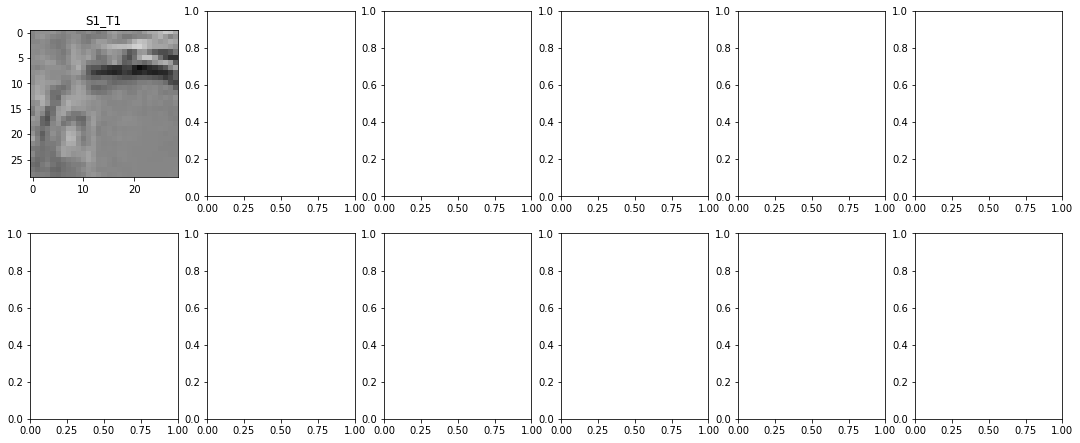

In [13]:
# x_train = np.array(trainingimages[0])
# y_train = np.array(traininglbls[0])
%matplotlib inline
fig,ax = plt.subplots(2,6)
fig.set_size_inches(18.5, 7.5)
mods = ['S1_T1','S1_T2','S1_FLAIR', 'delta_T1', 'delta_T2', 'delta_FLAIR']

islice = 10

for ii in range(0,6):
    ax[0,ii].imshow(x_train[islice,ii,:,:], cmap='gray',clim = [-5,5])
    ax[0,ii].title.set_text(mods[ii])
fig.canvas.set_window_title('x_train')
for ii in range(0,6):
    ax[1,ii].imshow(x_val[islice,ii,:,:], cmap='gray',clim = [-5,5])
    ax[1,ii].title.set_text(mods[ii])

(59539, 1, 29, 29) (6731, 1, 29, 29)


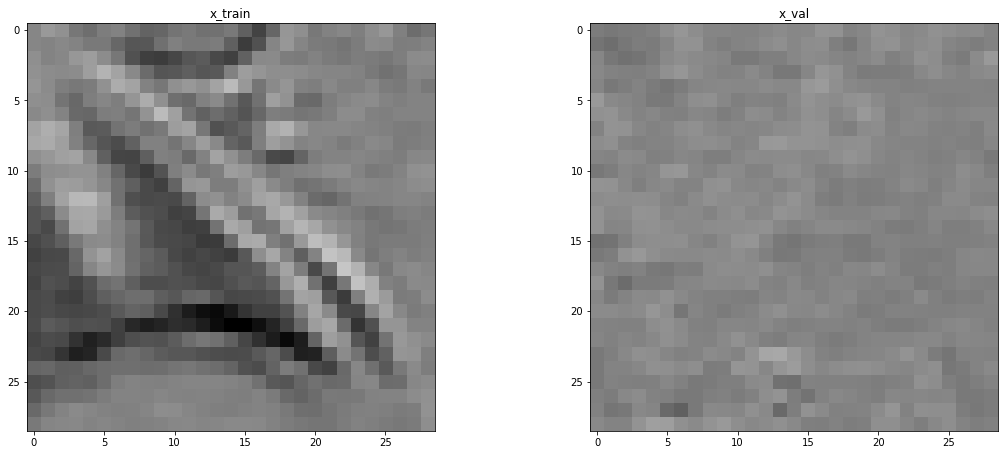

In [14]:
# x_train = np.array(trainingimages[0])
# y_train = np.array(traininglbls[0])
%matplotlib inline
fig,ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 7.5)
mods = ['S1_T1','S1_T2','S1_FLAIR', 'delta_T1', 'delta_T2', 'delta_FLAIR']

print(x_train.shape,x_val.shape)
islice = 40

ax[0].imshow(x_train[islice,0,:,:], cmap='gray',clim = [-5,5])
ax[0].title.set_text('x_train')

islice = 15
ax[1].imshow(x_val[islice,0,:,:], cmap='gray',clim = [-5,5])
ax[1].title.set_text('x_val')

In [10]:
#generate predictions
predict = model.predict(x_train, batch_size=1)
# print(predict)
predictmax = []
for pred in predict:
#     val, idx = max(pred);
    predictmax.append(np.argmax(pred))
# predictmax = amax(predict[])
# print(predictmax)

In [4]:
#save hdf5 file of predictions
import datetime #to put date in filename
outputDir = 'CNN_PREDICTIONS'
datestring = str(datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
outputFile = '%s/'%(outputDir) + datestring + 'Fold%d_Patches%d.hdf5'%(folds, pSize)
print('creating '+outputFile)
if not os.path.isdir(outputDir):
    os.makedirs(outputDir)
with h5py.File(outputFile,'w') as outFile:
    #create field indicating original dimensions
            _datashape = shape(predictmax)
            predictions = outFile.create_dataset('predictions', data = predictmax, shape=_datashape, compression="gzip")
            
#             _labelshape = [npatch]
#             labels = patchFile.create_dataset('labels', shape=_labelshape,dtype='uint8')

creating CNN_PREDICTIONS/20170719144113Fold1_Patches29.hdf5


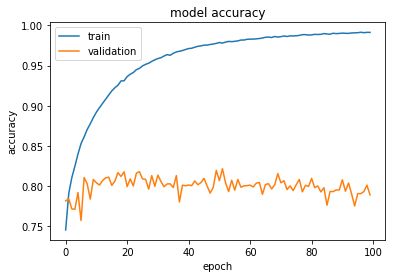

In [15]:
# plot summary

#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.plot(acc_folds)
# plt.plot(val_acc_folds)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

(46072, 29, 29, 6)


In [20]:
print(patchFile['labels'])

ValueError: Not a location (Invalid object id)

In [22]:
#testing
def DSI(seg,gt,lab):
    return 2.0*sum((seg==lab)&(gt==lab))/(sum(seg==lab)+sum(gt==lab))

dataDir = '../../MSpatientdata'
for subjectID in testIDs:
    #read test file
    outputFile = '%s/patient%s_testPatches%d.hdf5'%(outputDir, int(subjectID), pSize)
    with h5py.File(outputFile,'r') as patchFile:
        bSize = 100000
        N = patchFile.get('labels').shape[0]
        data = patchFile.get('data')
        p_labels = np.array([0]*N)
        for ibatch in range(0,N,bSize):
            #generate predictions
            tmp = data[ibatch:min(ibatch+bSize,N),5,:,:]
            predict = model.predict(tmp.reshape(tmp.shape[0], channels, img_x, img_y) )
            # print(predict)
            predictmax = []
            for pred in predict:
            #     val, idx = max(pred);
                predictmax.append(np.argmax(pred))
            #predicted_label = np.array([0]*bSize)
            #for i in range(bSize):#if categorical segmentation, not probability, needed
            #    predicted_label[i] = out['prob'][i].argmax(0)
            p_labels[ibatch:min(ibatch+bSize,N)] = predictmax[:min(ibatch+bSize,N)-ibatch]
        
        # populate the brainmask with the predictions
        srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'brainmask')
        inputImage = sitk.ReadImage(srcFile)
        mask = sitk.GetArrayFromImage(inputImage)>0
        seg = zeros(mask.shape)
        seg[mask] = p_labels
        
        outputImage = sitk.GetImageFromArray(seg)
        outputImage.CopyInformation(inputImage)
        outputImage = sitk.Cast(outputImage, sitk.sitkUInt8)

        sitk.WriteImage(outputImage, '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'seg0'),True)

        srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'gt3')
        gt = sitk.ReadImage(srcFile)
        gt = sitk.GetArrayFromImage(gt)

        print('%.2f %.2f %.2f'%(DSI(seg>0,gt>0,1),DSI(seg,gt,1),DSI(seg,gt,2)))

0.07 0.14 0.00
0.01 0.01 0.00
0.24 0.30 0.01


In [38]:
trainingIDs

array([16, 10,  5,  2,  7,  4, 19, 12,  6])

In [36]:
with h5py.File(outputFile,'r') as patchFile:
    data = patchFile.get('data')
    predict = model.predict(data[ibatch:min(ibatch+bSize,N),:])


In [29]:
def DSI(seg,gt,lab):
    return 2.0*sum((seg==lab)&(gt==lab))/(sum(seg==lab)+sum(gt==lab))
srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'gt3')
gt = sitk.ReadImage(srcFile)
gt = sitk.GetArrayFromImage(gt)

print('%.2f %.2f %.2f'%(DSI(seg>0,gt>0,1),DSI(seg,gt,1),DSI(seg,gt,2)))

0.08 0.21 0.00


In [51]:
#evaluation of test results:
def DSI(seg,gt,lab):
    return 2.0*sum((seg==lab)&(gt==lab))/(sum(seg==lab)+sum(gt==lab))

dataDir = '../../MSpatientdata'
for subjectID in testIDs:
    srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'seg0');
    seg = sitk.ReadImage(srcFile)
    seg = sitk.GetArrayFromImage(seg)

    srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'gt3')
    gt = sitk.ReadImage(srcFile)
    gt = sitk.GetArrayFromImage(gt)
        
    print('%.2f %.2f %.2f'%(DSI(seg>0,gt>0,1),DSI(seg,gt,1),DSI(seg,gt,2)))

0.04 0.23 0.00
0.04 0.19 0.00
0.08 0.21 0.00


(844248, 6, 29, 29)
844248
(6, 29, 29)


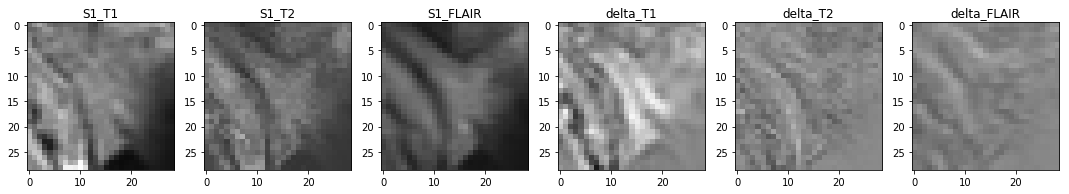

In [15]:
subjectID = 1
outputFile = '%s/patient%s_testPatches%d.hdf5'%(outputDir, int(subjectID), pSize)
with h5py.File(outputFile,'r') as patchFile:
    shape = patchFile.get('data').shape
    print(shape)
    shape = patchFile.get('labels').shape[0]
    print(shape)
    %matplotlib inline
    fig,ax = plt.subplots(1,6)
    fig.set_size_inches(18.5, 10.5)
    islice = 10000
    data = patchFile['data'][islice]
    print(data.shape)
    
    mods = ['S1_T1','S1_T2','S1_FLAIR', 'delta_T1', 'delta_T2', 'delta_FLAIR']
    for ii in range(0,6):
        ax[ii].imshow(data[ii,:,:], cmap='gray',clim = [-5,5])
        ax[ii].title.set_text(mods[ii])

In [3]:
outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
with h5py.File(outputFile,'r') as patchFile:
    trainingimages.append(patchFile['data'][()])
    print(size(trainingimages))

10


In [26]:
dataDir = '../../MSpatientdata'
srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'brainmask')
inputImage = sitk.ReadImage(srcFile)
mask = sitk.GetArrayFromImage(inputImage)>0
seg = zeros(mask.shape)
seg[mask] = 1

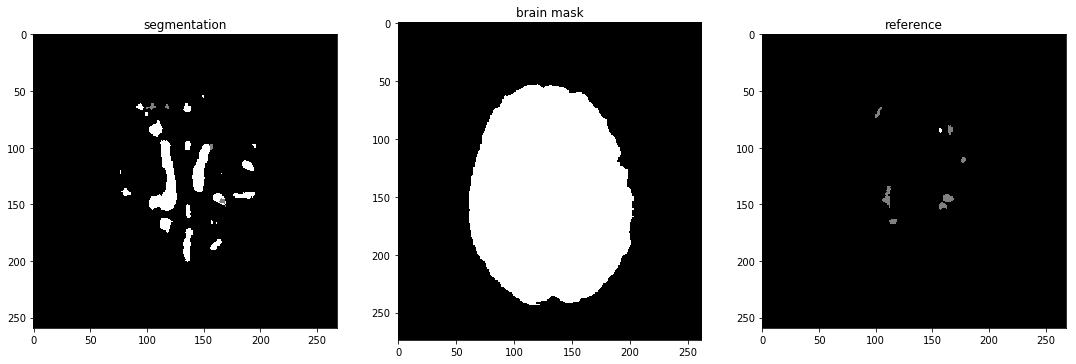

In [95]:
%matplotlib inline
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18.5, 10.5)
islice = 30
ax[0].imshow(seg[islice,:,:], cmap='gray')
ax[0].title.set_text('segmentation')
ax[1].imshow(mask[islice,:,:], cmap='gray')
ax[1].title.set_text('brain mask')
ax[2].imshow(gt[islice,:,:], cmap='gray')
ax[2].title.set_text('reference')